<div class="alert alert-block alert-info">

----------
---------
# <b> 1. Imports</b> 

--------------
----------------
</div>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

from torchvision import transforms   

from dataset import CorrosionDataset
from model import get_model


<div class="alert alert-block alert-info">

----------
---------
# <b> 2. Preparing datasets and data loaders</b> 

--------------
----------------
</div>

In [ ]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])


train_dataset = CorrosionDataset("../data/train.txt", transform)
val_dataset   = CorrosionDataset("../data/val.txt", transform)
test_dataset  = CorrosionDataset("../data/test.txt", transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

print("Train:", len(train_dataset), "Val:", len(val_dataset), "Test:", len(test_dataset))


Train: 571 Val: 122 Test: 123


<div class="alert alert-block alert-info">

----------
---------
# <b> 3. Initializing device, model, and training components</b> 

--------------
----------------
</div>

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = get_model().to(device) # Initializing model

criterion = nn.CrossEntropyLoss() # Defining loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Initializing optimizer
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

num_epochs = 20
patience = 5   # Defining early stopping patience

best_val_loss = float("inf")
no_improve = 0


<div class="alert alert-block alert-info">

----------
---------
# <b> 4. Training and Validation Loop</b> 

--------------
----------------
</div>

In [ ]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    

    model.train()
    running_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad() # Resetting gradients
        outputs = model(images)["out"]

        loss = criterion(outputs, masks) # Computing loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()  # Accumulating loss

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval() # VALIDATION
    val_loss_sum = 0.0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)["out"]
            loss = criterion(outputs, masks)

            val_loss_sum += loss.item()

    avg_val_loss = val_loss_sum / len(val_loader)
    val_losses.append(avg_val_loss)

    scheduler.step(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:     # Saveing the best model
        best_val_loss = avg_val_loss
        no_improve = 0
        torch.save(model.state_dict(), "../outputs/checkpoints/best_model.pth")
        print("  Saved: Best model updated!")
    else:
        no_improve += 1

    # EARLY STOPPING
    if no_improve >= patience:
        print("\nEARLY STOPPING TRIGGERED!") # Triggering early stopping
        break

print("Training finished.")


Epoch [1/20] | Train Loss: 0.3421 | Val Loss: 0.2192
 ✓ Saved: Best model updated!
Epoch [2/20] | Train Loss: 0.1981 | Val Loss: 0.1769
 ✓ Saved: Best model updated!
Epoch [3/20] | Train Loss: 0.1661 | Val Loss: 0.1691
 ✓ Saved: Best model updated!
Epoch [4/20] | Train Loss: 0.1363 | Val Loss: 0.1864
Epoch [5/20] | Train Loss: 0.1199 | Val Loss: 0.1644
 ✓ Saved: Best model updated!
Epoch [6/20] | Train Loss: 0.1164 | Val Loss: 0.1608
 ✓ Saved: Best model updated!
Epoch [7/20] | Train Loss: 0.0944 | Val Loss: 0.1881
Epoch [8/20] | Train Loss: 0.0959 | Val Loss: 0.1737
Epoch [9/20] | Train Loss: 0.0888 | Val Loss: 0.1573
 ✓ Saved: Best model updated!
Epoch [10/20] | Train Loss: 0.0729 | Val Loss: 0.1649
Epoch [11/20] | Train Loss: 0.0712 | Val Loss: 0.1824
Epoch [12/20] | Train Loss: 0.0658 | Val Loss: 0.1773
Epoch [13/20] | Train Loss: 0.0592 | Val Loss: 0.1786
Epoch [14/20] | Train Loss: 0.0529 | Val Loss: 0.1859

EARLY STOPPING TRIGGERED!
Training finished.


<div class="alert alert-block alert-info">

----------
---------
# <b> 5. Training Curve Visualization</b> 

--------------
----------------
</div>

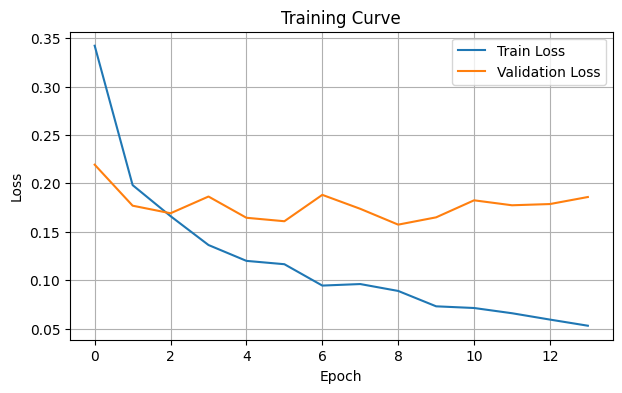

In [10]:
plt.figure(figsize=(7,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Curve")
plt.legend()
plt.grid(True)
plt.show()


<div class="alert alert-block alert-info">

----------
---------
# <b>6. Test Set Evaluation</b> 

--------------
----------------
</div>

In [11]:
def iou_score(pred, true):
    intersection = (pred & true).sum()
    union = (pred | true).sum()
    if union == 0: return 1
    return intersection / union

def dice_score(pred, true):
    intersection = (pred & true).sum()
    return (2 * intersection) / (pred.sum() + true.sum() + 1e-8)

model.load_state_dict(torch.load("../outputs/checkpoints/best_model.pth"))
model.eval()

ious, dices = [], []

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)["out"]
        preds = torch.argmax(outputs, dim=1)

        pred_np = preds.cpu().numpy().astype(bool)
        true_np = masks.cpu().numpy().astype(bool)

        ious.append(iou_score(pred_np, true_np))
        dices.append(dice_score(pred_np, true_np))

print("Mean IoU:", np.mean(ious))
print("Mean Dice:", np.mean(dices))


Mean IoU: 0.6612114610190919
Mean Dice: 0.7781165876989729


<div class="alert alert-block alert-info">

----------
---------
# <b> 7. Generating and saving test set predictions</b> 

--------------
----------------
</div>

In [13]:
from PIL import Image
import numpy as np
import os

save_dir = "../outputs/predictions"
os.makedirs(save_dir, exist_ok=True)

model.eval()

with torch.no_grad():
    for idx, (images, masks) in enumerate(test_loader):
        images = images.to(device)
        outputs = model(images)["out"]
        preds = torch.argmax(outputs, dim=1).cpu().numpy()[0]

        Image.fromarray((preds * 255).astype(np.uint8)).save(f"{save_dir}/pred_{idx}.png")

